# DFL - Decision-Focused Learning for VRPs
## Using SPO+ with heuristic solver

In [1]:
# load the autoreload extension
%load_ext autoreload
# set the level of reloading
%autoreload 2

In [2]:
from util import *
import torch
from heuristic.heuristic_solver import HeuristicSolver
from spo import *


In [31]:
# data = [parse_datafile(f'../data/cvrp_1000_100_4_8/instance_{i}') for i in range(15)]
# data = [parse_datafile(f'../data/cvrp_1000_100_4_8/instance_{i}') for i in range(100)]
# data = [parse_datafile(f'../data/cvrp_1000_10_5_8/instance_{i}') for i in range(1000)]
data = [parse_datafile(f'../data/cvrp_10000_25_4_8_0.1/instance_{i}') for i in range(10000)]

Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_0...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_1...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_2...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_3...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_4...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_5...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_6...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_7...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_8...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_9...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_10...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_11...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_12...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_13...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_14...
Parsing datafile: ../data/cvrp_10000_25_4_8_0.1/instance_15...
Pa

In [32]:
from tqdm import tqdm

# solve the VRPs with the actual edge costs and save the solutions
for vrp in tqdm(data):
    solver = HeuristicSolver(vrp)
    # solver = GurobiSolver(vrp)
    solver.solve()
    vrp.actual_solution = solver.get_decision_variables()
    vrp.actual_obj = solver.get_actual_objective()

100%|██████████| 10000/10000 [17:06<00:00,  9.74it/s]


In [33]:
e = torch.tensor([edge.features for edge in data[0].edges], dtype=torch.float32)
e.shape

torch.Size([600, 4])

In [34]:
TRAIN_PERCENTAGE = 0.75
VALIDATION_PERCENTAGE = 0.05
TEST_PERCENTAGE = 0.2

num_train = int(len(data) * TRAIN_PERCENTAGE)
num_val = int(len(data) * VALIDATION_PERCENTAGE)
num_test = int(len(data) * TEST_PERCENTAGE)

vrps_train = data[:num_train]
vrps_val = data[num_train:num_train + num_val]
vrps_test = data[num_train + num_val:]
print(f'Number of training instances: {len(vrps_train)}')
print(f'Number of validation instances: {len(vrps_val)}')
print(f'Number of test instances: {len(vrps_test)}')

Number of training instances: 7500
Number of validation instances: 500
Number of test instances: 2000


In [35]:

from gnn import GNN

num_nodes = len(vrps_train[0].nodes)
num_edges = len(vrps_train[0].edges)
num_feat = len(vrps_train[0].edges[0].features)
cost_model = CostPredictor(num_edges * num_feat, num_edges)
# cost_model = GNN(num_feat, vrps_train[0].edges)

optimizer = torch.optim.Adam(cost_model.parameters(), lr=1e-3)
spo_plus = SPOplus()
num_epochs = 30
for epoch in range(num_epochs):
    mean_loss = 0
    for idx, vrp in tqdm(enumerate(vrps_train)):
        optimizer.zero_grad()
        # get the edge features and indices
        edge_features = torch.tensor([edge.features for edge in vrp.edges])
        predicted_edge_costs = cost_model(edge_features)
        # set the predicted edge costs
        for i, edge in enumerate(vrp.edges):
            edge.predicted_cost = predicted_edge_costs[i]
        # calculate the loss
        solver = HeuristicSolver(vrp, mode=SolverMode.SPO, max_runtime=0.1)
        # solver = GurobiSolver(vrp, mode=SolverMode.SPO)
        solver.solve()
        loss = spo_plus(predicted_edge_costs, vrp.actual_solution, vrp.actual_obj, solver.get_decision_variables(),
                        solver.get_spo_objective())
        # backpropagation
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        # print(f'Epoch {epoch + 1} / {num_epochs}, instance {idx + 1} / {len(vrps_train)}, loss: {loss.item()}')
    mean_loss /= len(vrps_train)
    print(
        f'Epoch {epoch + 1} / {num_epochs} done, mean loss: {mean_loss}, val loss: {validation_loss(cost_model, vrps_val, spo_plus, HeuristicSolver)}')
    if (epoch + 1) % 5 == 0:
        test(cost_model, vrps_test, HeuristicSolver, is_two_stage=False)

7500it [14:57,  8.36it/s]


Epoch 1 / 30 done, mean loss: 4001274.3086208333, val loss: 3898875.0


7500it [15:46,  7.93it/s]


Epoch 2 / 30 done, mean loss: 4061972.8690291666, val loss: 4136438.25


525it [01:03,  8.20it/s]


KeyboardInterrupt: 

In [ ]:
optimizer = torch.optim.Adam(cost_model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 30
for epoch in range(num_epochs):
    mean_loss = 0
    for idx, vrp in tqdm(enumerate(vrps_train)):
        optimizer.zero_grad()
        # get the edge features and indices
        edge_features = torch.tensor([edge.features for edge in vrp.edges])
        predicted_edge_costs = cost_model(edge_features)
        # set the predicted edge costs
        for i, edge in enumerate(vrp.edges):
            edge.predicted_cost = predicted_edge_costs[i]
        # calculate the loss
        solver = HeuristicSolver(vrp, mode=SolverMode.SPO, max_runtime=0.1)
        # solver = GurobiSolver(vrp, mode=SolverMode.SPO)
        solver.solve()
        loss = spo_plus(predicted_edge_costs, vrp.actual_solution, vrp.actual_obj, solver.get_decision_variables(),
                        solver.get_spo_objective())
        # backpropagation
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        # print(f'Epoch {epoch + 1} / {num_epochs}, instance {idx + 1} / {len(vrps_train)}, loss: {loss.item()}')
    mean_loss /= len(vrps_train)
    print(
        f'Epoch {epoch + 1} / {num_epochs} done, mean loss: {mean_loss}, val loss: {validation_loss(cost_model, vrps_val, spo_plus, HeuristicSolver)}')
    if (epoch + 1) % 5 == 0:
        test(cost_model, vrps_test, HeuristicSolver, is_two_stage=False)

7500it [15:32,  8.04it/s]


Epoch 1 / 30 done, mean loss: 4063495.3159458335, val loss: 3914737.0


4439it [09:25,  8.33it/s]


Interrupt request received


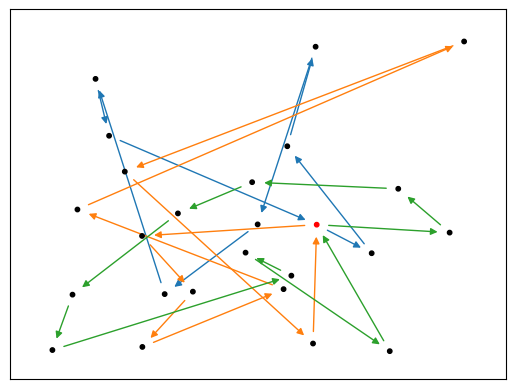

15788.641843866546

In [42]:
# testing
# vrp = vrps_train[10]
vrp = vrps_test[10]

solver = GurobiSolver(vrp)
solver.solve()
draw_solution(solver)
solver.get_actual_objective()

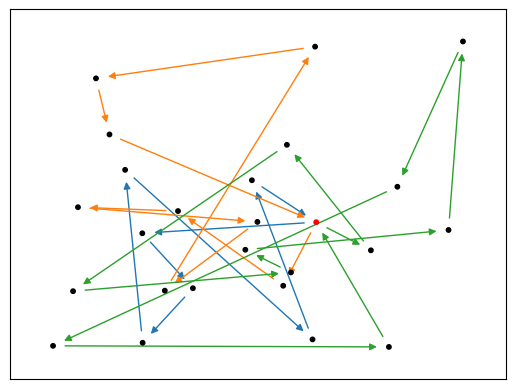

28140.026889541903

In [43]:
solver = HeuristicSolver(vrp)
solver.solve()
draw_solution(solver)
solver.get_actual_objective()

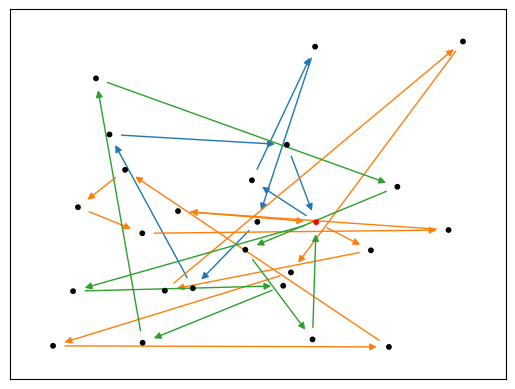

301719.2361257134

In [44]:
predicted_edge_costs = cost_model(torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32))
for i, edge in enumerate(vrp.edges):
    edge.predicted_cost = predicted_edge_costs[i]
solver = HeuristicSolver(vrp, mode=SolverMode.PRED_COST, max_runtime=0.1)
# solver = GurobiSolver(vrp, mode=SolverMode.PRED_COST)
solver.solve()
draw_solution(solver)
solver.get_actual_objective()

In [45]:
test(cost_model, vrps_test, HeuristicSolver, is_two_stage=False)

Parsed instance VRP instance: ../data/cvrp_10000_25_4_8_0.1/instance_8000, accuracy: 0.07692307692307693, actual cost: 7306.7432228994285, predicted cost: 121430.1212120844
Parsed instance VRP instance: ../data/cvrp_10000_25_4_8_0.1/instance_8001, accuracy: 0.23076923076923078, actual cost: 16136.09677594293, predicted cost: 193061.70019198087
Parsed instance VRP instance: ../data/cvrp_10000_25_4_8_0.1/instance_8002, accuracy: 0.42307692307692313, actual cost: 30919.974397909027, predicted cost: 352278.4415448912
Parsed instance VRP instance: ../data/cvrp_10000_25_4_8_0.1/instance_8003, accuracy: 0.6153846153846154, actual cost: 40088.672716763074, predicted cost: 619965.4960594589
Parsed instance VRP instance: ../data/cvrp_10000_25_4_8_0.1/instance_8004, accuracy: 0.7307692307692308, actual cost: 52608.648512449996, predicted cost: 929027.338065154
Parsed instance VRP instance: ../data/cvrp_10000_25_4_8_0.1/instance_8005, accuracy: 0.9230769230769231, actual cost: 66473.64691306005, p